In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.plot_utility import scatter_plot #this replace matplotlib

from utils.stratified_splitting import sampling # for stratified sampling

from gd_dpo.GDDPO import GD_DPO #main model

from poly_rings.DPO import DPO_generate #function SMILES -> DPO polynomials

from trainer import Trainer #all in one class

all_data = pd.read_csv("sample_DATA\\total_dataset.csv",index_col = "No")
all_data.head()

,DPO equation,BG,IP,EA,smiles
No,,,,,
P4.1,1+2*b,4.837,6.134,1.297,c12c3ccccc3c4ccccc4c1cccc2
P4.2,1+2*b,4.168,5.812,1.644,c1(c(ccc2c1cccc2)cc3)c4c3cccc4
P4.3,1+b+d,4.207,5.799,1.592,c1(ccccc1cc2)c3c2c4ccccc4cc3
P4.4,2-a+b,3.720,5.599,1.879,c1(ccccc1cc2cc3)cc2c4c3cccc4
P4.5,3-3*a,2.747,5.131,2.384,c12cc3cc4ccccc4cc3cc1cccc2


In [2]:
"""
##################################################
# converting smiles to truncated DPO polynomials #
##################################################
"""

smiles1 = all_data.loc["F8.1","smiles"] 
#SMILES string taken from dataset, which is generated with OpenBabel
polynomials1 = DPO_generate(smiles1)
print("Example 1/ SMILES string:",smiles1,'\n',"=> DPO = ",polynomials1,"\n----------------\n")

"""
Tips: you can Ctrl + Alt + P to paste SMILES string to ChemDraw -> structure
Reversely, you can Ctrl + Alt + C to copy a structure as SMILES string to clipboard
"""

smiles2 = "C1(C=CS2)=C2C=C(C=C(C=CC3=C4C=C5C(C(C=CC=C6)=C6C7=C5SC=C7)=C3)C4=C8)C8=C1"
#SMILES string generated from ChemDraw
polynomials2 = DPO_generate(smiles2)
print("Example 2/ SMILES string:",smiles2,'\n',"=> DPO = ",polynomials2,"\n----------------\n")

Example 1/ SMILES string: s1ccc2cc3cc4cc5cc6c(cc7c8c(ccc7c6)cccc8)cc5cc4cc3cc12 
 => DPO =  ((6 - 15*a - af + b*d**0))*(1/1) 
----------------

Example 2/ SMILES string: C1(C=CS2)=C2C=C(C=C(C=CC3=C4C=C5C(C(C=CC=C6)=C6C7=C5SC=C7)=C3)C4=C8)C8=C1 
 => DPO =  ((3 - 3*a - af + b*d**0 + b*d**1 + c*df**1 + (1 - 0*a)*d**2))*(1/1) 
----------------



-----------DATA PREPARATION--------------------
Number of samples in training set: 132 samples


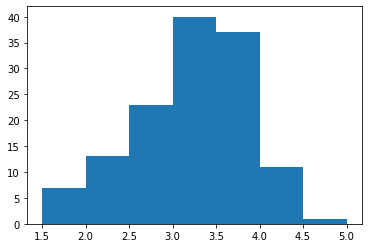

Histogram of band gap distribution for training set
Number of samples in test set: 116 samples


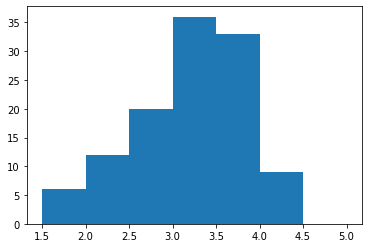

Histogram of band gap distribution for test set


In [3]:
"""
Preparing training set of 132 samples and test set of 116 samples
"""

print("-----------DATA PREPARATION--------------------")
#sampling for the train set
train_set = sampling(
    132, all_data, 
    intervals = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    random_state = 100
)
print("Number of samples in training set: {} samples".format(
    len(train_set)))

# take SMILES strings from dataset convert -> truncated DPO
X_train = train_set.loc[:,"smiles"].apply(DPO_generate)
# take "true" value
Y_train = np.array(train_set.loc[:,"BG"])

Y_ea_train = np.array(train_set.loc[:,"EA"])
Y_ip_train = np.array(train_set.loc[:,"IP"])

plt.hist(Y_train,bins = [1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
plt.show()
print("Histogram of band gap distribution for training set")

#drop index of the training set from all data -> test set
test_set = all_data.drop(train_set.index)
print("Number of samples in test set: {} samples".format(
    len(test_set)))
# same
X_test = test_set.loc[:,"smiles"].apply(DPO_generate)
Y_test = np.array(test_set.loc[:,"BG"])

Y_ea_test = np.array(test_set.loc[:,"EA"])
Y_ip_test = np.array(test_set.loc[:,"IP"])

plt.hist(Y_test,bins = [1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
plt.show()
print("Histogram of band gap distribution for test set")

In [7]:
"""
#####################################################
# Run a ML-based full DPO model using GD_DPO module #
#####################################################
"""

# initiate model
model = GD_DPO(
    parameters_list = ["a","b","c","d","af","df"], #symbols used in DPO polynomials
    constant_list = [], #symbols that are not subjected to learning
    constant_values = [], #their values
    tasks = 3 #number of linear equations, each for predicting a elec. prop.
)

print("-----------TRAINING--------------------")
# fit the model to train set and test set. 
# This method fits the DPO parameters
# By default, task indexed 0 is used
model.fit(
    X_train, Y_train, 
    lr = 0.1, 
    epochs = 400,
    verbose = 200
)

# call feedforward only compute the weights of linear equations, 
# using arg task to select what linear equation to used 
# (0th is for the one that is used in fit method above)
model.feedforward(X_train,Y_ea_train,task = 1)
model.feedforward(X_train,Y_ip_train,task = 2)

#compute loss of the model in training set
mse = model.compute_loss(X_train,Y_train)
print("\nRMSD for band gap on training set: ",np.sqrt(mse))

mse = model.compute_loss(X_train,Y_ea_train,task = 1) #don't forget to use task to select linear equation
print("RMSD for EA on training set: ",np.sqrt(mse))

mse = model.compute_loss(X_train,Y_ip_train,task = 2)
print("RMSD for IP on training set: ",np.sqrt(mse))

print("\n-----------TESTING--------------------")
#compute RMSD of trained model on test set

#compute RMSD of trained model on test set
mse = model.compute_loss(X_test,Y_test)
print("\nRMSD on test set: ",np.sqrt(mse))

mse = model.compute_loss(X_test,Y_ea_test,task = 1) #don't forget to use task to select linear equation
print("RMSD for EA on test set: ",np.sqrt(mse))

mse = model.compute_loss(X_test,Y_ip_test,task = 2)
print("RMSD for IP on test set: ",np.sqrt(mse))

print("\n-----------PREDICTING--------------------")
smiles = all_data.loc["F8.1","smiles"] #take an sample from the total set
dpo = DPO_generate(smiles) #generate DPO polynomials
print("SMILES string: ",smiles)

x, y_hat = model.predict(dpo) #compute prediction

print("predicted band gap: {:.2f}; true value: {:.2f}".format(
    y_hat[0],all_data.loc["F8.1","BG"]))

x, y_hat = model.predict(dpo,task = 1) #compute prediction

print("predicted EA: {:.2f}; true value: {:.2f}".format(
    y_hat[0],all_data.loc["F8.1","EA"]))

x, y_hat = model.predict(dpo,task = 2) #compute prediction

print("predicted IP: {:.2f}; true value: {:.2f}".format(
    y_hat[0],all_data.loc["F8.1","IP"]))

-----------TRAINING--------------------
Epoch 200: loss: 0.010606029618249151
[ 0.08271211 -0.11070434  0.34328074  0.26909127  0.38240707  0.15287957]
Epoch 400: loss: 0.010465574562875987
[ 0.07304167 -0.1152668   0.37333336  0.28483372  0.39753653  0.17925329]

RMSD for band gap on training set:  0.10230139081594143
RMSD for EA on training set:  0.06956903549348413
RMSD for IP on training set:  0.05761259192772563

-----------TESTING--------------------

RMSD on test set:  0.10248739442347772
RMSD for EA on test set:  0.06537331207887791
RMSD for IP on test set:  0.056711119015868075

-----------PREDICTING--------------------
SMILES string:  s1ccc2cc3cc4cc5cc6c(cc7c8c(ccc7c6)cccc8)cc5cc4cc3cc12
predicted band gap: 1.70; true value: 1.74
predicted EA: 2.94; true value: 2.92
predicted IP: 4.64; true value: 4.66


In [8]:
"""
Data splitting, preparation, model training, testing as above
can be done multiple times in a couple of lines using Trainer
"""
trainer = Trainer(
    data = all_data,           # all data where training set and test set are drawn from
    SMILES = True,             # in case not using truncated DPO, switch this to False
    descriptor_col = "smiles", # and change this to the name of the alternate column (e.g DPO equation)
    target_col = 'BG',         # property that the DPO parameters are fitted
    pred_col = ["EA","IP"],    # properties that only weights of linear eq are fitted 
    data_intervals = [1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5], # bins for stratified splitting
    parameters_list = ['a','b','c','d','af','df'],            # list of symbols for optimization
    parameter_values = None, # initial values of above. Set to None to initiate as zeros
    constant_list = [],      # symbols that are not meant to optimized
    constant_values = [],    # their values
    global_seed = 47
)

# commit training and test the model multiple times
model = trainer.repeat_standard_train(
    n = 10,                 # number of runs
    train_set_size = 132,   # number of samples in training set
    test_set_size = 116,    # number of samples in test set
    verbose = False         # you won't know how many runs have completed
    )
# the returned main_model is the model for predicting target_col property
# the returned list of models models are model for predicting pred_col properties
# all returned model has parameters averaged over all runs

print("RESULT for BG: RMSE = {}".format(
        trainer.test_rmse))
for i,elec_prop in enumerate(trainer.pred_col):
    print("RESULT for {}: RMSE = {}".format(
        elec_prop,trainer.pred_test_rmse[i]))
    
print("\nML-BASED DPO MODEL CONFIGURATION")

print("DPO PARAMETERS: ")
for i,param in enumerate(model.parameters_list):
    print(param," = ", model.parameter_values[i])

print("\nLINEAR WEIGHT ([bias, slope])")
print(trainer.target_col,model.outputs[0].weight)

for i, prop in enumerate(trainer.pred_col):
    print(prop, model.outputs[i+1].weight) 


##########################
##REPEAT TRAINING RESULT##
##########################
Train on training set size of 132
Repeating training for 10 times, average result reported.
Train RMSE: 0.1031.
Test RMSE: 0.1026.

Finish, total run time: 116.10789346694946 s
RESULT for BG: RMSE = 0.10257667439922069
RESULT for EA: RMSE = 0.06474808328089496
RESULT for IP: RMSE = 0.05960689779059865

ML-BASED DPO MODEL CONFIGURATION
DPO PARAMETERS: 
a  =  0.07606194615382252
b  =  -0.13141838199835137
c  =  0.3434618952053293
d  =  0.285531999820616
af  =  0.4196434592914039
df  =  0.15030258735824473

LINEAR WEIGHT ([bias, slope])
BG (4.97192126426269, -0.7514325124333753)
EA (1.195591643228698, 0.40123039201154)
IP (6.167443682257325, -0.35015555145023847)


In [9]:
print("\n-----------PREDICTING--------------------")
smiles = all_data.loc["F8.5","smiles"]
print("SMILES string: ",smiles)

dpo = DPO_generate(smiles)

#predicting. Returned are DPO values and predicted value.
x, bg_hat = model.predict(dpo,task = 0)

x, ea_hat = model.predict(dpo,task = 1)

x, ip_hat = model.predict(dpo,task = 2)

print("predicted band gap: {:.2f}; true value: {:.2f}".format(
    bg_hat[0],all_data.loc["F8.5","BG"]))
print("predicted EA: {:.2f}; true value: {:.2f}".format(
    ea_hat[0],all_data.loc["F8.5","EA"]))
print("predicted IP: {:.2f}; true value: {:.2f}".format(
    ip_hat[0],all_data.loc["F8.5","IP"]))


-----------PREDICTING--------------------
SMILES string:  s1ccc2cc3c(cc12)cc1cc2c4c(ccc2cc1c3)ccc1cc2ccccc2cc41
predicted band gap: 2.39; true value: 2.35
predicted EA: 2.57; true value: 2.58
predicted IP: 4.96; true value: 4.93


In [12]:
"""
Training with few data points
"""

trainer2 = Trainer(
    data = all_data,           # all data where training set and test set are drawn from
    SMILES = True,             # in case not using truncated DPO, switch this to False
    descriptor_col = "smiles", # and change this to the name of the alternate column (e.g DPO equation)
    target_col = 'BG',         # property that the DPO parameters are fitted
    pred_col = ["EA","IP"],    # properties that only weights of linear eq are fitted 
    data_intervals = [1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5], # bins for stratified splitting
    parameters_list = ['a','b','c','d','af','df'],            # list of symbols for optimization
    parameter_values = None, # initial values of above. Set to None to initiate as zeros
    constant_list = [],      # symbols that are not meant to optimized
    constant_values = [],    # their values
    global_seed = 47
)

# commit training and test the model multiple times
model = trainer2.repeat_standard_train(
    n = 20,                 # number of runs
    train_set_size = 26,    # number of samples in training set
    test_set_size = 116,     # number of samples in test set
    verbose = 0
    )

print("RESULT for BG: RMSE = {}".format(
        trainer.test_rmse))
for i,elec_prop in enumerate(trainer.pred_col):
    print("RESULT for {}: RMSE = {}".format(
        elec_prop,trainer.pred_test_rmse[i]))
    
print("\nML-BASED DPO MODEL CONFIGURATION")

print("DPO PARAMETERS: ")
for i,param in enumerate(model.parameters_list):
    print(param," = ", model.parameter_values[i])

print("\nLINEAR WEIGHT ([bias, slope])")
print(trainer.target_col,model.outputs[0].weight)

for i, prop in enumerate(trainer.pred_col):
    print(prop, model.outputs[i+1].weight) 


##########################
##REPEAT TRAINING RESULT##
##########################
Train on training set size of 26
Repeating training for 20 times, average result reported.
Train RMSE: 0.0826.
Test RMSE: 0.1237.

Finish, total run time: 58.032371520996094 s
RESULT for BG: RMSE = 0.10257667439922069
RESULT for EA: RMSE = 0.06474808328089496
RESULT for IP: RMSE = 0.05960689779059865

ML-BASED DPO MODEL CONFIGURATION
DPO PARAMETERS: 
a  =  0.05835158751563746
b  =  -0.10796545941584645
c  =  0.3509018718866238
d  =  0.28663746603874884
af  =  0.4216236070807282
df  =  0.14849662159442234

LINEAR WEIGHT ([bias, slope])
BG (4.933705306437785, -0.7164825261442612)
EA (1.2063207193430903, 0.3857632490987953)
IP (6.139898475596986, -0.3306454469292235)
